In [883]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [884]:
PREPARED_DATASET_PATH = './housing_prepared.csv'
TRAIN_DATASET_PATH = '../housing_train.csv'
CALIFORNIA_MAP_PATH = 'california.png'

In [885]:
df = pd.read_csv(PREPARED_DATASET_PATH, sep=';')
df.head(4)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,housing_median_age_nan,ocean_proximity_nan,longitude_outlier,latitude_outlier,population_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,0,0.365909,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,0,0.338217,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,0,0.338105,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,0,0.437991,0,0,0,1,0


In [886]:
# Заменяем latitude/longitude на два кластера (города), и дистанцию от центра к этим кластерам
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=100, random_state=42)

In [887]:
X_train_labels = kmeans.fit_predict(df[['latitude', 'longitude', 'INLAND']])
X_train_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [888]:
df['cluster'] = X_train_labels

df['cluster_0'] = 0
df['cluster_1'] = 0

df.loc[X_train_labels == 0, 'cluster_0'] = 1
df.loc[X_train_labels == 1, 'cluster_1'] = 1

In [889]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,housing_median_age_nan,...,latitude_outlier,population_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,cluster,cluster_0,cluster_1
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,...,0,0.365909,0,0,0,1,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,...,0,0.338217,0,0,0,1,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,...,0,0.338105,0,0,0,1,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,...,0,0.437991,0,0,0,1,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,...,0,0.347265,0,0,0,1,0,0,1,0


In [890]:
# Вычисляем дистанцию до центров городов

city_centroids = np.array([[37.4975, -122.2075], [34.1522, -118.6437]])
city_centroids

array([[  37.4975, -122.2075],
       [  34.1522, -118.6437]])

In [891]:
df.loc[df['cluster'] == 0, 'cluster_lat'] = city_centroids[0][0]
df.loc[df['cluster'] == 0, 'cluster_long'] = city_centroids[0][1]
df.loc[df['cluster'] == 1, 'cluster_lat'] = city_centroids[1][0]
df.loc[df['cluster'] == 1, 'cluster_long'] = city_centroids[1][1]
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,housing_median_age_nan,...,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,cluster,cluster_0,cluster_1,cluster_lat,cluster_long
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,...,0,0,0,1,0,0,1,0,37.4975,-122.2075
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,...,0,0,0,1,0,0,1,0,37.4975,-122.2075
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,...,0,0,0,1,0,0,1,0,37.4975,-122.2075
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,...,0,0,0,1,0,0,1,0,37.4975,-122.2075
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,...,0,0,0,1,0,0,1,0,37.4975,-122.2075


In [892]:
df['distance_to_center_squared'] = (df['longitude']**2 - df['cluster_long']**2)**2 + (df['latitude']**2 - df['cluster_lat'])
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,housing_median_age_nan,...,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,cluster,cluster_0,cluster_1,cluster_lat,cluster_long,distance_to_center_squared
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,...,0,0,1,0,0,1,0,37.4975,-122.2075,1427.645181
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,...,0,0,1,0,0,1,0,37.4975,-122.2075,1405.217225
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,...,0,0,1,0,0,1,0,37.4975,-122.2075,1458.240775
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,...,0,0,1,0,0,1,0,37.4975,-122.2075,1503.065541
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,...,0,0,1,0,0,1,0,37.4975,-122.2075,1503.065541


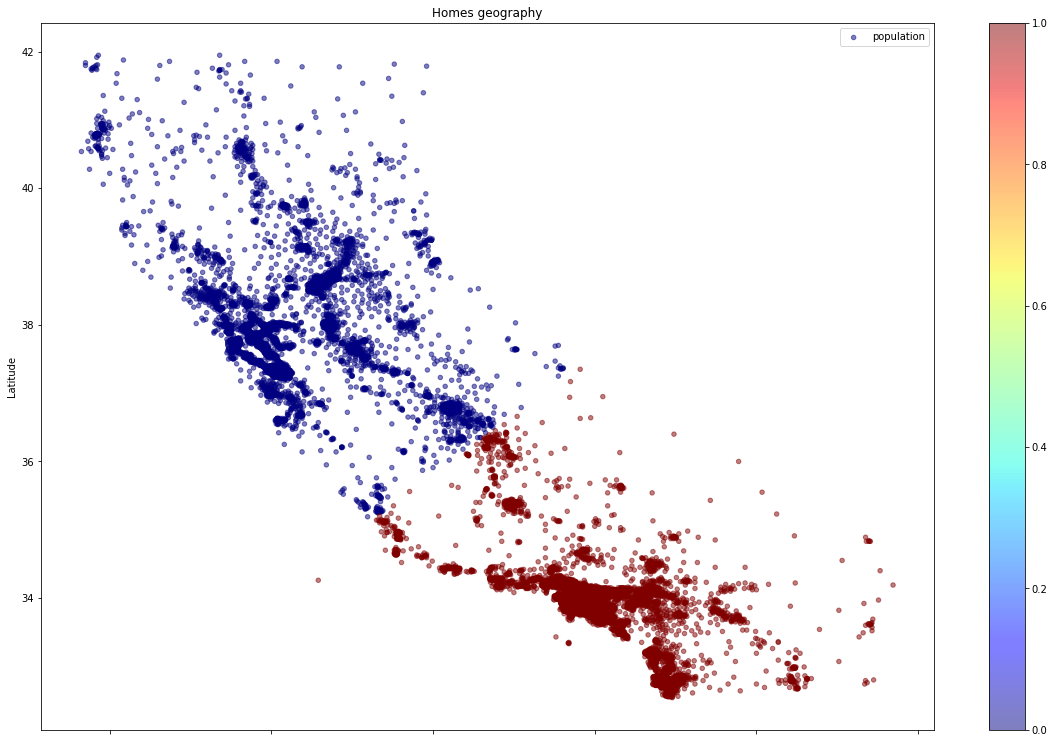

In [893]:
california_map = img.imread(CALIFORNIA_MAP_PATH)

df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5, label='population', c=X_train_labels, 
        cmap=plt.get_cmap('jet'), figsize=(20,13))

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Homes geography")
plt.legend() 

plt.show()

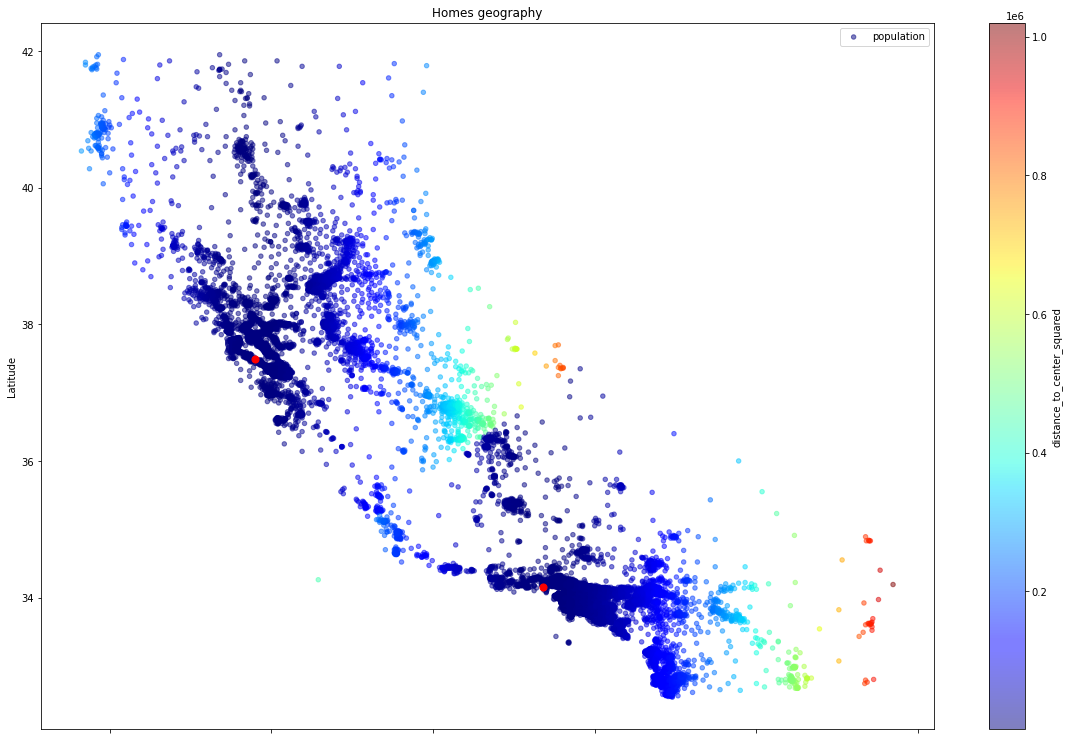

In [894]:
california_map = img.imread(CALIFORNIA_MAP_PATH)

df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5, label='population', c='distance_to_center_squared', 
        cmap=plt.get_cmap('jet'), figsize=(20,13))

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Homes geography")
plt.legend() 

plt.scatter(city_centroids[:, 1], city_centroids[:, 0], c='red', s=50)

plt.show()

In [895]:
df.drop(columns=['cluster', 'cluster_long', 'cluster_lat'], inplace=True)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,housing_median_age_nan,...,latitude_outlier,population_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,cluster_0,cluster_1,distance_to_center_squared
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,...,0,0.365909,0,0,0,1,0,1,0,1427.645181
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,...,0,0.338217,0,0,0,1,0,1,0,1405.217225
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,...,0,0.338105,0,0,0,1,0,1,0,1458.240775
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,...,0,0.437991,0,0,0,1,0,1,0,1503.065541
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,...,0,0.347265,0,0,0,1,0,1,0,1503.065541


In [896]:
feature_names = df.columns.tolist()
feature_names.remove('median_house_value')

target_name = 'median_house_value'

feature_names_for_stand = df[feature_names].select_dtypes(include=['float64','int64']).columns.tolist()
feature_names_for_stand

scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,housing_median_age_nan,...,latitude_outlier,population_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,cluster_0,cluster_1,distance_to_center_squared
0,-1.330277,1.036473,1.025853,-1.137723,-1.348849,-0.982678,-0.978640,2.959952,452600.0,-0.189052,...,-0.01009,-0.560393,-0.881005,-0.704248,-0.015954,2.901549,-0.376027,1.164906,-1.164906,-0.598431
1,-1.325291,1.027171,-0.603438,3.450773,2.196127,0.855759,1.661028,2.944799,358500.0,-0.189052,...,-0.01009,-0.618133,-0.881005,-0.704248,-0.015954,2.901549,-0.376027,1.164906,-1.164906,-0.598659
2,-1.335263,1.022519,1.921963,-0.704623,-1.127515,-0.828811,-0.845613,2.280068,352100.0,-0.189052,...,-0.01009,-0.618366,-0.881005,-0.704248,-0.015954,2.901549,-0.376027,1.164906,-1.164906,-0.598121
3,-1.340249,1.022519,1.921963,-0.847022,-0.964235,-0.773985,-0.736062,1.252220,341300.0,-0.189052,...,-0.01009,-0.410101,-0.881005,-0.704248,-0.015954,2.901549,-0.376027,1.164906,-1.164906,-0.597666
4,-1.340249,1.022519,1.921963,-0.586572,-0.800956,-0.767795,-0.631727,0.108107,342200.0,-0.189052,...,-0.01009,-0.599267,-0.881005,-0.704248,-0.015954,2.901549,-0.376027,1.164906,-1.164906,-0.597666


In [897]:
df.to_csv(TRAIN_DATASET_PATH, index=False, encoding='utf-8')